# Libraries

In [16]:
# General
import pandas as pd
import numpy as np

# Data Management
from dataclasses import dataclass, field
from collections import namedtuple
from typing import List, Any
import pickle

# Solar Position to Time of Day Calculation
from pvlib import solarposition
from scipy.optimize import minimize_scalar

# Graphing
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Time Handling. Also so that pandas .dt.time series plays nice with matploblib.
from datetime import datetime, date, time

# Stats
from scipy import stats

# Random Forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.feature_selection import SelectKBest, f_classif # for finding best features
import optuna # for finding best features

# Data Import

## Functions

In [2]:
# Convert timestamps to datetimes
def convert_unixtime(df, column, format = None, unit = None, new_name = "datetime"):
    df[new_name] = pd.to_datetime(df[column], format = format, unit = unit)

# Clean data
def cleaner(df, variable_name):
    df[variable_name] = df[variable_name].replace([-9999.0], np.nan) # Replace visible/known missing values
    df = df.reindex(pd.date_range(start = df.index[0], end = df.index[-1], freq = "30min")) # Reindex to deal with hidden missing values
    #df.index.name = "date" # put the name of the index column back!
    df = df[[variable_name]].copy()
    return df

def calc_time_by_solar(latitude, longitude, date, target_elevation, target_azimuth):

    # Minimize the difference in solar position
    def objective(mins_since_midnight):
        dt = date + pd.Timedelta(minutes = mins_since_midnight)
        pos = solarposition.get_solarposition(dt, latitude, longitude)
        elev = pos["apparent_elevation"].values[0]
        azim = pos["azimuth"].values[0]
        return (elev - target_elevation)**2 + (azim - target_azimuth)**2
    
    # Optimize over a 24-hour period
    res = minimize_scalar(objective, bounds = (0, 1440), method = "bounded") # using 1440 for number of mins in 24 hours. Don"t need more resolution than this
    recovered_datetime = date + pd.Timedelta(minutes = res.x) # Get the time of day (res.x) and add it to the input date.
    
    return recovered_datetime

def normalise_azimuth(df, column):
    for idx, azimuth in enumerate(df[column]):
        # If azimuth is less than 0, add 360 to make it in the 0 to 360 range.
        if azimuth < 0:
            df.at[idx, column] = azimuth + 360

## Data

Declare my dataclass to contain my data. We create a dataclass (simplifed way to make a class). It means we can build a custom data structure to hold all our data sources. Neat and tidy.

In [17]:
coordinates = namedtuple("coordinates", ["lat", "lon"])

@dataclass
class class_data:
    flux: pd.DataFrame
    satellite: pd.DataFrame
    paired: pd.DataFrame
    training: pd.DataFrame
    stats: dict
    coords: coordinates

Construct and populate class_data fields and import data

In [ ]:
flux_cols = [
    "TIMESTAMP_END",
    "GPP_DT_VUT_REF", # gross primary production
    #"SWC_F_MDS_1", # soil water content at depth 1, gap-filled with MDS
    #"SWC_F_MDS_2", # soil water content at depth 2, gap-filled with MDS
    ]

data = {
    "se_st1": class_data(
        flux = pd.read_csv(
            "../data/raw/flux/abisko-stordalen-grassland/FLX_SE-St1_FLUXNET2015_FULLSET_HH_2012-2019_beta-3.csv", 
            usecols = flux_cols
        ),
        satellite = pd.read_csv("../data/raw/satellite/tundra-flux_abisko-stordalen-grassland.csv"),
        paired = pd.DataFrame(),
        training = pd.DataFrame(),
        stats = {},
        coords = coordinates(68.35415, 19.050333),
    ),    
    "se_sto": class_data(
        flux = pd.read_csv(
            "../data/raw/flux/abisko-stordalen-palsa-bog/ICOSETC_SE-Sto_FLUXNET_HH_L2.csv", 
            usecols = flux_cols
        ),
        satellite = pd.read_csv("../data/raw/satellite/tundra-flux_abisko-stordalen-palsa-bog.csv"),
        paired = pd.DataFrame(),
        training = pd.DataFrame(),
        stats = {},
        coords = coordinates(68.35594288, 19.04520892),
    ),
    "fi_ken": class_data(
        flux = pd.read_csv(
            "../data/raw/flux/kenttarova/ICOSETC_FI-Ken_FLUXNET_HH_L2.csv",
            usecols = flux_cols
        ),
        satellite = pd.read_csv("../data/raw/satellite/tundra-flux_kenttarova.csv"),
        paired = pd.DataFrame(),
        training = pd.DataFrame(),
        stats = {},
        coords = coordinates(67.98721, 24.24301),
    ),
    "fi_sod": class_data(
        flux = pd.read_csv(
            "../data/raw/flux/sodankyla/ICOSETC_FI-Sod_FLUXNET_HH_L2.csv",
            usecols = flux_cols
        ),
        satellite = pd.read_csv("../data/raw/satellite/tundra-flux_sodankyla.csv"),
        paired = pd.DataFrame(),
        training = pd.DataFrame(),
        stats = {},
        coords = coordinates(67.36239, 26.63859),
    ),
    "fi_var": class_data(
        flux = pd.read_csv(
            "../data/raw/flux/varrio/ICOSETC_FI-Var_FLUXNET_HH_L2.csv",
            usecols = flux_cols
        ),
        satellite = pd.read_csv("../data/raw/satellite/tundra-flux_varrio.csv"),
        paired = pd.DataFrame(),
        training = pd.DataFrame(),
        stats = {},
        coords = coordinates(67.7549, 29.61),
    )
}

## Pre-processing

Pre-process flux data

In [ ]:
for key, item in data.items():
    
    df = item.flux
    
    # Rename Columns
    df = df.rename(columns = {
    "TIMESTAMP_END": "unixtime",
    "GPP_DT_VUT_REF": "gpp",
    "SWC_F_MDS_1": "swc_1",
    "SWC_F_MDS_2": "swc_2"
    })
    
    # Convert times
    convert_unixtime(df, "unixtime", "%Y%m%d%H%M")
    df = df.set_index("datetime", drop = False) # Make the new datetime column the index
    df["time_of_day"] = [datetime.combine(date(2025, 5, 24), t) for t in df["datetime"].dt.time] # Add Time of Day. https://stackoverflow.com/questions/32832431/how-to-use-datetime-time-to-plot
    df['time_of_day_frac'] = ( # Convert "time_of_day" from datetime object into milliseconds
        df['time_of_day'].dt.hour * 3600000 +
        df['time_of_day'].dt.minute * 60000 +
        df['time_of_day'].dt.second * 1000 +
        df['time_of_day'].dt.microsecond // 1000
    )  / 86400000.0 # convert to fraction of day 0 - 0.999...
    df['time_of_day_sin'] = np.sin(2 * np.pi * df['time_of_day_frac'])
    df['time_of_day_cos'] = np.cos(2 * np.pi * df['time_of_day_frac'])
    df["day_of_year"] = df["datetime"].dt.dayofyear # Add Day of Year. Returns 1 for January 1st
    df['day_of_year_sin'] = np.sin(2 * np.pi * df["day_of_year"] / 365) # convert into a cyclical features (https://harrisonpim.com/blog/the-best-way-to-encode-dates-times-and-other-cyclical-features)
    df['day_of_year_cos'] = np.cos(2 * np.pi * df["day_of_year"] / 365)
    
    # Sort
    df.sort_index(inplace = True)
    
    # Clean
    df = pd.concat([cleaner(df[[column]].copy(), column) for column in df.columns], axis = 1) # Clean and reassign dataframe
    
    data[key].flux = df

Pre-process satellite data

In [ ]:
for key, item in data.items():
    
    df = item.satellite
    
    # Convert times
    convert_unixtime(df, "unixtime", unit = "ms")
        
    # Calculate time of day for awkward satellites
    normalise_azimuth(df, "solar_azimuth")
    mask = df["platform_id"].isin(["MOD09GA", "MYD09GA", "VNP09GA"]) # Filter the dataframe to satellites without time of day
    masked_df = df.loc[mask] # Filter our df to the platform_id mask
    masked_df.loc[:, "datetime"] = masked_df["datetime"].dt.normalize()
    for idx, row in masked_df.iterrows():
        recovered_datetime = calc_time_by_solar(
            latitude = data[key].coords.lat,
            longitude = data[key].coords.lon,
            date = row["datetime"],
            target_elevation = row["solar_elevation"],
            target_azimuth = row["solar_azimuth"]
            )
        df.loc[idx, "datetime"] = recovered_datetime
    
    # Create datetime derivitives
    df = df.set_index("datetime", drop = False) # Set datetime to index
    df.rename_axis(None, inplace = True) # Remove the index column header (otherwise using .merge won"t work when creating the paired dataset)
    df["time_of_day"] = [datetime.combine(date(2025, 5, 24), t) for t in df["datetime"].dt.time] # Add Time of Day. https://stackoverflow.com/questions/32832431/how-to-use-datetime-time-to-plot
    df['time_of_day_frac'] = ( # Convert "time_of_day" from datetime object into milliseconds
        df['time_of_day'].dt.hour * 3600000 +
        df['time_of_day'].dt.minute * 60000 +
        df['time_of_day'].dt.second * 1000 +
        df['time_of_day'].dt.microsecond // 1000
    )  / 86400000.0 # convert to fraction of day 0 - 0.999...
    df['time_of_day_sin'] = np.sin(2 * np.pi * df['time_of_day_frac'])
    df['time_of_day_cos'] = np.cos(2 * np.pi * df['time_of_day_frac'])
    df["day_of_year"] = df["datetime"].dt.dayofyear # Add Day of Year. Returns 1 for January 1st
    df['day_of_year_sin'] = np.sin(2 * np.pi * df["day_of_year"] / 365) # convert into a cyclical features
    df['day_of_year_cos'] = np.cos(2 * np.pi * df["day_of_year"] / 365)
    
    # Homogenise unixtime lengths
    df["unixtime"] = df["datetime"].astype(int) / 10**9 # Remake unixtime from datetime (we"re remaking it so the flux and satellite unix times are the same length)
    
    # Sort data by index (datetime)
    df.sort_index(inplace = True)
    
    data[key].satellite = df

import pickle
with open(f"imported_data.pkl", 'wb') as f:
        pickle.dump(data, f)

# Processing Satellite Data
Now that our data are cleaned and have nice variable names we can process them.

In [68]:
data = None
with open("imported_data.pkl", 'rb') as f:
    data = pickle.load(f)

## Harmonisation
Not all bands are created equal. The width of each between satellites varies. This may cause some slight issues when we create our indices and try to analyse the data as if it were one. We can try and adjust for this by harmonising the data with a form of bias correction.

## Indices
Let"s create some indices from our band values to identify primary productivity and soil moisture. Drawing a lot of inspiration from beaver et al. reduced set for these indices

In [69]:
def calculate_indices(df):
    
    # Bands
    blue = df["blue"]
    green = df["green"]
    red = df["red"]
    nir = df["nir"]
    swir_1 = df["swir_1"]
    swir_2 = df["swir_2"]
    
    # Vegetation Primary Production, chlorophyll, etc. Indices
    df["ndvi"] = (nir - red) / (nir + red) # Normalised difference vegetation index
    #df["savi"] = ( 1.5 * ( nir - red ) ) / ( nir + red + 0.5 ) # soil adjusted vegetation index: Huete, A. "A Soil-Adjusted Vegetation Index (SAVI)." Remote Sensing of Environment 25 (1988): 295-309.
    df["msavi"] = (2 * nir + 1 - np.sqrt((2 * nir + 1) ** 2 - 8 * (nir - red))) / 2 # Modified soil adjusted index 2: Qi, J., A. Chehbouni, A. Huete, Y. Kerr, and S. Sorooshian. "A Modified Soil Adjusted Vegetation Index." Remote Sensing of Environment 48 (1994): 119-126.
    df["nirv"] = ((nir - red) / (nir + red) - 0.08) * nir # Near Infra-red index (for vegetation that deals with soil and is a proxy for SIF (which is a value required to calculate GPP!))
    df["kndvi"] = np.tanh((nir - red) ** 2 / (2 * (0.5 * (nir + red)) ** 2)) # kNDVI. Kernel ndvi. better against noise and non-linearity. https://www.science.org/doi/10.1126/sciadv.abc7447 - a nice review of nirv and ndvi too!
    df["vsf"] = df["ndvi"] * df["msavi"] # Vgetation supressing factor https://www.sciencedirect.com/science/article/pii/S0303243422000290?via%3Dihub
    df["tvi"] = 0.5 * ( 120 * ( nir - green ) - 200 * ( red - green ) ) # Triangular vegetation index. https://www.sciencedirect.com/science/article/pii/S0034425700001978?via%3Dihub
    # INF VALS df["bmsr"] = ( nir - blue ) / ( red - blue ) # Blue modified simple ratio: https://www.sciencedirect.com/science/article/pii/S003442570200010X?via%3Dihub
    df["cri2"] = ( 1 / green ) - ( 1 / red ) # Carotenoid reflectance index 2: https://onlinelibrary.wiley.com/doi/abs/10.1562/0031-8655%282001%290740038OPANEO2.0.CO2 
    df["mndvi"] = ( nir - red ) / ( nir + red - 2 * blue ) # Modified ndvi: https://www.sciencedirect.com/science/article/pii/S003442570200010X?via%3Dihub
    df["mnli"] = ( nir*nir - red ) * ( 1 + 0.5 ) / ( nir*nir + red + 0.5) # Modified non-linear vegetation index: Yang, Z., P. Willis, and R. Mueller. "Impact of Band-Ratio Enhanced AWIFS Image to Crop Classification Accuracy." Proceedings of the Pecora 17 Remote Sensing Symposium (2008), Denver, CO.    VIA: https://mapir.gitbook.io/mapir-camera-control-mcc/multispectral-index-formulas
    df["evi"] = 2.5 * ( ( nir - red ) / ( nir + 6 * red - 7.5 * blue + 1 ) ) # Enhanced vegetation index: Huete, A., et al. "Overview of the Radiometric and Biophysical Performance of the MODIS Vegetation Indices." Remote Sensing of Environment 83 (2002):195–213.
    df["lai"] = 3.618 * ( 2.5 * ( ( nir - red ) / ( nir + 6 * red - 7.5 * blue + 1 ) ) ) - 0.118 # Leaf area index: Boegh, E., H. Soegaard, N. Broge, C. Hasager, N. Jensen, K. Schelde, and A. Thomsen. "Airborne Multi-spectral Data for Quantifying Leaf Area Index, Nitrogen Concentration and Photosynthetic Efficiency in Agriculture." Remote Sensing of Environment 81, no. 2-3 (2002): 179-193.
    df["fci2"] = red * nir # forest cover index 2: Becker, Sarah J., Craig S.T. Daughtry, and Andrew L. Russ. "Robust forest cover indices for multispectral images." Photogrammetric Engineering & Remote Sensing 84.8 (2018): 505-512.    VIA: https://mapir.gitbook.io/mapir-camera-control-mcc/multispectral-index-formulas
    df["gemi"] = ( ( 2 * ( nir*nir - red*red ) + 1.5 * nir + 0.5 * red ) / ( nir + red + 0.5 ) ) * ( 1 - 0.25 * ( ( 2 * ( nir*nir - red*red ) + 1.5 * nir + 0.5 * red ) / ( nir + red + 0.5 ) ) ) - ( ( red - 0.125 ) / ( 1 - red ) ) # global environmental monitoring index: Pinty, B., and M. Verstraete. GEMI: a Non-Linear Index to Monitor Global Vegetation From Satellites. Vegetation 101 (1992): 15-20.    VIA: https://mapir.gitbook.io/mapir-camera-control-mcc/multispectral-index-formulas
    df["gari"] = ( nir - green - 1.7 * ( blue - red ) ) / ( nir + green - 1.7 * ( blue - red ) ) # Green atmospherically resistant index: Gitelson, A., Y. Kaufman, and M. Merzylak. "Use of a Green Channel in Remote Sensing of Global Vegetation from EOS-MODIS." Remote Sensing of Environment 58 (1996): 289-298.
    df["gci"] = ( nir / green ) - 1 # Green chlorophyll index: Gitelson, A., Y. Gritz, and M. Merzlyak. "Relationships Between Leaf Chlorophyll Content and Spectral Reflectance and Algorithms for Non-Destructive Chlorophyll Assessment in Higher Plant Leaves." Journal of Plant Physiology 160 (2003): 271-282.
    df["gndvi"] = ( nir - green ) / ( nir + green ) # Green ndvi:Gitelson, A., and M. Merzlyak. "Remote Sensing of Chlorophyll Concentration in Higher Plant Leaves." Advances in Space Research 22 (1998): 689-692.
    df["gosavi"] = ( nir - green ) / ( nir + green + 0.16 ) # Green optimised savi (for predicting crop nitrogen requirements) Sripada, R., et al. "Determining In-Season Nitrogen Requirements for Corn Using Aerial Color-Infrared Photography." Ph.D. dissertation, North Carolina State University, 2005.
    df["grvi"] = nir / green # Green ratio vegetation index (photosynthesis in forest canopy): Sripada, R., et al. "Aerial Color Infrared Photography for Determining Early In-season Nitrogen Requirements in Corn." Agronomy Journal 98 (2006): 968-977.
    df["gsavi"] = 1.5 * ( ( nir - green ) / ( nir + green + 0.5 ) ) # green savi (nitrogen requirements in corn): Sripada, R., et al. "Determining In-Season Nitrogen Requirements for Corn Using Aerial Color-Infrared Photography." Ph.D. dissertation, North Carolina State University, 2005.
    df["nli"] = ( nir*nir - red ) / ( nir*nir + red ) # Non-linear index: Goel, N., and W. Qin. "Influences of Canopy Architecture on Relationships Between Various Vegetation Indices and LAI and Fpar: A Computer Simulation." Remote Sensing Reviews 10 (1994): 309-347.
    df["osavi"] = ( nir - red ) / ( nir + red + 0.16 ) # optimised soil adjusted vegetation index: Rondeaux, G., M. Steven, and F. Baret. "Optimization of Soil-Adjusted Vegetation Indices." Remote Sensing of Environment 55 (1996): 95-107.
    #df["rdvi"] = ( nir - red ) / np.sqrt( nir + red) # Renormalised difference vegetation index (highlights healthy veg, sun angle and soil don't affect it!): Roujean, J., and F. Breon. "Estimating PAR Absorbed by Vegetation from Bidirectional Reflectance Measurements." Remote Sensing of Environment 51 (1995): 375-384.
    df["tdvi"] = 1.5 * ( ( nir - red ) / np.sqrt( nir*nir + red + 0.5 ) ) # Transformed difference vegetation index (does not saturate like ndvi, for use in urban environs): Bannari, A., H. Asalhi, and P. Teillet. "Transformed Difference Vegetation Index (TDVI) for Vegetation Cover Mapping" In Proceedings of the Geoscience and Remote Sensing Symposium, IGARSS '02, IEEE International, Volume 5 (2002).
    #df["vari"] = ( green- red ) / ( green + red - blue ) # Visible atmospheric resistant index: Gitelson, A., et al. "Vegetation and Soil Lines in Visible Spectral Space: A Concept and Technique for Remote Estimation of Vegetation Fraction. International Journal of Remote Sensing 23 (2002): 2537−2562.
    df["wdrvi"] = ( 0.2 * nir - red ) / ( 0.2 * nir + red ) # wide dynamic range vegetation index (weights nir and red to reduce signal disparity and stop over-saturation): Gitelson, A. "Wide Dynamic Range Vegetation Index for Remote Quantification of Biophysical Characteristics of Vegetation." Journal of Plant Physiology 161, No. 2 (2004): 165-173. AND Henebry, G., A. Viña, and A. Gitelson. "The Wide Dynamic Range Vegetation Index and its Potential Utility for Gap Analysis." Gap Analysis Bulletin 12: 50-56.
    df["msrvi"] = ( ( nir ) / ( red - 1 ) ) / ( np.sqrt( nir / red ) + 1 ) # Modified simple ratio vegetation index: https://www.sciencedirect.com/science/article/pii/S0378112719304736?via%3Dihub
    df["mtvi"] = 1.2 * ( 1.2 * ( nir - green ) - 2.5 * ( red  - green ) ) # modified tvi: https://www.sciencedirect.com/science/article/pii/S0034425704000264?via%3Dihub
    df["npci"] = ( red - blue ) / ( red + blue ) # normalised pigment chlorophyll index: Penuelas, J., Baret, F., and Filella, I. 1995. “Semi-empirical indices to assess carotenoids/chlorophyll a ratio from leaf spectral reflectance.” Photosynthetica, Vol. 31(No. 2): pp. 221–230.
    df["psri"] = ( red - green ) / nir # plant senescence reflectance index: https://onlinelibrary.wiley.com/doi/10.1034/j.1399-3054.1999.106119.x
    df["rgvi"] = red / green # red-green vegetation index: https://www.sciencedirect.com/science/article/pii/S0034425705002865?via%3Dihub
    df["spectral_polygon"] = 0.4 * ( 3.7 * ( nir - red ) - 1.2 * ( green - red) ) # Spectral Polygon: Vincini, M., Frazzi, E., and D’Alessio, P. 2006. Angular dependence of maize and sugar beet VIs from directional CHRIS/Proba data. Proc. 4th ESA CHRIS PROBA Workshop, 19–21
    #df["sipi"] = ( nir - blue ) / ( nir - red ) # Structure insensitive pigment index: Penuelas, J., Baret, F., and Filella, I. 1995. “Semi-empirical indices to assess carotenoids/chlorophyll a ratio from leaf spectral reflectance.” Photosynthetica, Vol. 31(No. 2): pp. 221–230.
    
    ## Vegetation Water Indices
    #df["msi"] = swir_1 / nir # Moisture Stress Index (vegetation water stress)
    #df["gvmi"] = (nir + 0.1 - swir_1 + 0.02) / (nir + 0.1 + swir_1 + 0.02) # Global vegetation moisture index
    #df["ndmi"] = ( nir - swir_1 ) / ( nir + swir_1 ) # nd mositure index: https://www.sciencedirect.com/science/article/pii/0273117782902435?via%3Dihub
    
    # Water Indices
    #df["ndwi"] = (nir - swir_1) / (nir + swir_1) # Normalised difference water index
    #df["mndwi"] = (green - swir_1) / (green + swir_1) # Modified normalised difference water index: https://www.tandfonline.com/doi/full/10.1080/01431160600589179
    #df["wi"] = 1.7204 + 171 * green + 3 * red - 70 * nir - 45 * swir_1 - 71 * swir_2 # Water index. https://www.sciencedirect.com/science/article/pii/S0034425715302753
    #df["andwi"] = ( blue + green + red - nir - swir_1 - swir_2 ) / ( blue + green + red + nir + swir_1 + swir_2 ) # Augmented Normalized Difference Water Index https://www.sciencedirect.com/science/article/pii/S1364815221000736?via%3Dihub#bib29
    #df["mbwi"] = 2 * green - red - nir - swir_1 - swir_2 # Multiband water index. https://www.sciencedirect.com/science/article/pii/S0303243418300990?via%3Dihub
    #df["muwir"] = -4 * ( (blue - green ) / ( blue + green ) ) + 2 * ( (green - nir ) / ( green + nir ) ) + 2 * ( (green - swir_2 ) / ( green + swir_2 ) ) - 1 * ( (green - swir_1 ) / ( green + swir_1 ) ) # Revised Multi-Spectral Water Index. https://www.mdpi.com/2072-4292/10/10/1643
    #df["swm"] = ( blue + green ) / ( nir + swir_1 ) # Sentinel water mask. https://eoscience.esa.int/landtraining2017/files/posters/MILCZAREK.pdf
    #df["wri"] = ( green + red ) / ( nir + swir_1 ) # Water ratio index: https://ieeexplore.ieee.org/document/5567762
    #
    ## Snow Indices
    #df["tsi"] = (red - nir) / (red + nir) # Terrible snow index (not an actual index)
    #df["ndsi"] = ( green - swir_1 ) / ( green + swir_1 ) # Normalised difference snow index
    #df["swi"] = ( green * ( nir - swir_1 ) ) / ( green + nir ) * ( nir + swir_1 ) # Snow water index
    #
    ## Soil Indices
    #df["bsi"] = ( ( swir_2 + red ) - (nir + blue)) / ( ( swir_2 + red ) + ( nir + blue ) ) # Barren soil index. https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/barren_soil/
    #df["bi"] =  red + swir_1 + nir # Bareness index. https://ieeexplore.ieee.org/document/1525743
    #df["dbsi"] = ( swir_1 - green ) / ( swir_1 + green ) # Dry bare soil index  https://www.mdpi.com/2073-445X/7/3/81
    #df["bitm"] = np.sqrt( ( ( blue * blue ) + ( green * green ) + ( red * red ) ) / 3 ) # Brightness index. Soil reflectance magnitude. https://www.sciencedirect.com/science/article/pii/S0034425798000303?via%3Dihub
    #df["nsdsi1"] = ( swir_1 - swir_2 ) / swir_1 # Normalized Shortwave-Infrared Difference Bare Soil Moisture Index. https://www.sciencedirect.com/science/article/pii/S0924271619301522?via%3Dihub
    #df["nsdsi2"] = ( swir_1 - swir_2 ) / swir_2 # Normalized Shortwave-Infrared Difference Bare Soil Moisture Index. https://www.sciencedirect.com/science/article/pii/S0924271619301522?via%3Dihub
    #df["nsdsi3"] = ( swir_1 - swir_2 ) / ( swir_1 + swir_2 ) # Normalized Shortwave-Infrared Difference Bare Soil Moisture Index. https://www.sciencedirect.com/science/article/pii/S0924271619301522?via%3Dihub
    #df["bsmi"] = ( swir_1 - red ) / ( swir_1 + red ) # Bare soil moisture index
    #
    ## Other Indices
    #df["ndpi"] = ( swir_1 - green ) / ( swir_1 + green ) # Normalised difference pond index (maybe useful for bog?). https://www.sciencedirect.com/science/article/pii/S0034425706002811?via%3Dihub
    #df["nbr2"] = (swir_1 - swir_2) / (swir_1 + swir_2) # Normalised burn ratio 2. For burn but useful for water
    #
    ## # Bog indices (my own)
    #df["bi"] = df["ndvi"] * df["mndwi"] # Bog index. Made up by me. Bogs are wet and vegetation so the values of both indices combined may = bog
    #df["nbi"] = ( df["ndvi"] - df["mndwi"] ) * ( 1 - np.abs(df["ndvi"] - df["mndwi"] ) ) # Normalised bog index. Boosts values where ndvi and mndwi are similar (like in bogs) but supresses large differences e.g. open water or dry land.
    #df["bmi"] = ( df["ndvi"] - df["mndwi"] ) / ( 2 - np.abs(df["ndvi"] - df["mndwi"] ) ) # Bog moisture index
    #def sigmoid(x, k=10):
    #    return 1 / (1 + np.exp(-k * (x - 0.5)))  # Sigmoid function centered at 0.5
    #df["lbi"] =  sigmoid(df["ndvi"] - 0.4) * sigmoid(df["mndwi"] - 0.1) # logistic bog index (boost with sigmoid)

    return df

And make sure we clean the normalised difference indices so our dataframe only has row values in these columns between 1 and -1.

In [70]:
def clean_nd_indices(df):
    ndvi = df["ndvi"]
    #ndwi = df["ndwi"]
    #tsi = df["tsi"]
    #msavi = df["msavi"]
    #nsdsi1 = df["nsdsi1"]
    #nsdsi2 = df["nsdsi2"]
    #nsdsi3 = df["nsdsi3"]
    
    mask = (ndvi > -1) & (ndvi < 1) #& (ndwi > -1) & (ndwi < 1) & (tsi > -1) & (tsi < 1) & (msavi > -1) & (msavi < 1) & (nsdsi1 > -1) & (nsdsi1 < 1) & (nsdsi2 > -1) & (nsdsi2 < 1) & (nsdsi3 > -1) & (nsdsi3 < 1)
    
    return df[mask]

Let"s apply these functions to our satellite data.

In [71]:
for key, item in data.items():
    
    df = item.satellite
    
    df = calculate_indices(df)
    df = clean_nd_indices(df)
    #df = df[df["lai"] <= 3.5] # remove rows where lai is above 3.5
    
    data[key].satellite = df

c:\Users\Laurie\Files\Education\Postgraduate Degree\Modules\GEOGM0062 Dissertation MSc Climate Change Science and Policy\Processing and Analysis\arctic-ecosystems\.venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Laurie\Files\Education\Postgraduate Degree\Modules\GEOGM0062 Dissertation MSc Climate Change Science and Policy\Processing and Analysis\arctic-ecosystems\.venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Laurie\Files\Education\Postgraduate Degree\Modules\GEOGM0062 Dissertation MSc Climate Change Science and Policy\Processing and Analysis\arctic-ecosystems\.venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Laurie\Files\Education\Postgrad

# Training Preparation
Our satellite indices are a little meaningless. Whilst we know that, for example, NDVI has a strong linear (ish) relationship with gross primary production, it isn"t gross primary production. It is a proxy.

Let"s fix that by training a random forest regressor model on our data!

This way we can make our satellite record show an estimate of GPP. It"s the best of both worlds; *in situ* data and a long-term record.

For a similar method (and a whole load of indices) see: Beaver, J., Humphreys, E. R. and King, D. (2024) 'Random Forest Development and Modeling of Gross Primary Productivity in the Hudson Bay Lowlands', Canadian Journal of Remote Sensing, 50(1), https://doi.org/10.1080/07038992.2024.2355937.

### Pairing the Data

If we are to find relationships between our satellite and flux data we need to merge the two dataframes. We can do so based on **time**. Our flux data is half-hourly (!) so we just need to find the closest one of these for each of our satellite acquisition times (Hence all that messing about earlier on with datetimes and solar position...).

However, whilst pairing our data with flux tower gpp within max 15 minutes is rather snazzy, it's not what we really want to do. If we were to do this form of pairing we would be modelling the relationship between satellite and flux tower. But that what we want right? NO! This would produce a timeseries with GPP estimates from each satellite image at whatever time of day the image was taken. For our timeseries to be useful, we need a GPP timeseries and that is temporally consistent between days. What we really need is a model that can estimate a fixed/common GPP from satellite imagery acquired at any time...

In [72]:
for key, item in data.items():
    
    df = item.flux
    #item.flux = df[df["time_of_day"] == "2025-05-24 12:00:00"]
    
    df_midday = df.loc[(df.index.time >= pd.to_datetime("10:00").time()) & (df.index.time <= pd.to_datetime("14:00").time())] # only around midday values
    item.flux = df.resample('D').mean() # find the mean
    item.flux["day_of_year"] = item.flux["day_of_year"].astype("int32") # keep day_of_year as integer even though the mean action just changed it to a float

In [73]:
for key, item in data.items():
    
    df_flux = item.flux.copy()
    df_satellite = item.satellite.copy()
    
    # Clip satellite to flux tower min and max times
    datetime_start = df_flux["datetime"].min()
    datetime_end = df_flux["datetime"].max()
    df_satellite = df_satellite.dropna(subset = ["datetime"])
    df_satellite_subset = df_satellite[(df_satellite["datetime"] >= datetime_start) & (df_satellite["datetime"] <= datetime_end)]
    
    # Merge Satellite and Flux data by nearest datetime column values
    df_paired = pd.merge_asof(
        df_satellite_subset.sort_index(), df_flux.sort_index(), # should be sorted already, but why take the chance!
        left_on = "datetime", right_on = "datetime",
        direction = "nearest",
        suffixes = ("", "_flux") # keep satellite cols without suffix so that when we apply the random forest model we dont have to change col names. Append _flux to duplicate flux cols
    )
    
    # Set index on new paired dataframe
    df_paired = df_paired.set_index("datetime")
    
    data[key].paired = df_paired # Remember, we already defined "paired" as a dataframe in our class, how convenient!

### Drop Unwanted columns

Remove the unwanted columns, mainly datetime objects which cannot be passed to into the training pipeline.

In [74]:
col_filter = ["platform_id",
              #"solar_elevation",
              #"blue", "green", "red", "nir", "swir_1", "swir_2",
              #"day_of_year_cos", "day_of_year_sin",
              "unixtime", "datetime", "time_of_day", "day_of_year", "unixtime_flux", "swc_1", "swc_2", "time_of_day_flux", "day_of_year_flux", "day_of_year_cos_flux", "day_of_year_sin_flux", "time_of_day_cos_flux", "time_of_day_frac_flux", "time_of_day_sin_flux", "unixtime_flux", "time_of_day_frac"]

for key, item in data.items():
    df_undropped = item.paired.copy()
    data[key].training = df_undropped.drop(columns = col_filter, errors = "ignore")

### Remove Low NDVI values (aka winter/snow rows)
This time we are removing below 0.1 NDVI values. Just like beaver et al. This cleans the data up so we don't get any anomalous values when the in-situ GPP is ~0. This helps stop mislead/confuse the random forest model training.

**I'm don't think this is a clever idea. I want the full cycle and my model seems to work absolutely fine with it! I also don't want to miss the spring melt period as it could be quite important!**

plt.figure(figsize=(20, 6))
plt.scatter(data["fi_var"].training.index, data["fi_var"].training["nirv"])

for key, item in data.items():
    
    df_unfiltered = item.training.copy()
    
    df_filtered = df_unfiltered[df_unfiltered["ndvi"] >= 0.1]
    
    data[key].training = df_filtered
    
plt.scatter(data["fi_var"].training.index, data["fi_var"].training["nirv"], alpha = 0.2)

# Train Random Forest Regressor
Using our paired dataset we can now use a random forest decision tree to train a regressor model to quantify the relationship between our satellite data and flux tower gross primary production and soil moisture variables. (*oooh*)

#### Import

In [75]:
from sklearn.base import BaseEstimator
from sklearn.feature_selection._base import SelectorMixin
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer, root_mean_squared_error, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import TimeSeriesSplit
from sklearn.base import BaseEstimator, TransformerMixin
from pybaselines.utils import whittaker_smooth
from scipy import stats
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.tree import plot_tree
from sklearn.base import BaseEstimator, TransformerMixin
from filterpy.kalman import KalmanFilter
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor

#### Pipeline Transformers

In [76]:
class HighCorrelationFilter(BaseEstimator, SelectorMixin):
    def __init__(self, threshold = 0.9):
        self.threshold = threshold
        self.to_drop_ = []
        self.support_mask_ = None

    def fit(self, X, y=None):
        # Convert to DataFrame if needed
        X_df = pd.DataFrame(X)

        # Compute correlation matrix
        corr_matrix = X_df.corr().abs()
        upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

        # Find features to drop
        self.to_drop_ = [col for col in upper_triangle.columns if any(upper_triangle[col] > self.threshold)]

        # Create support mask
        self.support_mask_ = np.array([col not in self.to_drop_ for col in X_df.columns])

        return self

    def _get_support_mask(self):
        if self.support_mask_ is None:
            raise ValueError("fit must be called before get_support()")
        return self.support_mask_

    def transform(self, X):
        # Apply support mask
        X_df = pd.DataFrame(X)
        return X_df.loc[:, self._get_support_mask()]

    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            return None
        mask = self._get_support_mask()
        return np.array(input_features)[mask]

class rfecv_feature_filter(BaseEstimator, SelectorMixin):
    def __init__(self, no_kfolds=5, seed=2):
        self.no_kfolds = no_kfolds
        self.seed = seed
        self.support_mask_ = None
        self.selector_ = None

    def fit(self, X, y):
        
        # Ensure X is a DataFrame for column alignment
        X_df = pd.DataFrame(X)
        
        # Use RandomForestRegressor as the base estimator
        estimator = RandomForestRegressor(random_state=self.seed)

        # Cross-validation strategy
        #cv = KFold(n_splits=self.no_kfolds, shuffle=False, random_state=self.seed) # NEVER SHUFFLE A TIMESERIES
        cv = TimeSeriesSplit(n_splits = self.no_kfolds) # Makes sure test data is after train data in each kfold.
        
        scorer = make_scorer(mean_squared_error, greater_is_better=False)
        
        # Run RFECV
        self.selector_ = RFECV(estimator, step=1, cv=cv, scoring=scorer)
        self.selector_.fit(X_df, y)

        # Store the mask
        self.support_mask_ = self.selector_.support_

        return self

    def transform(self, X):
        X_df = pd.DataFrame(X)
        return X_df.loc[:, self._get_support_mask()]

    def _get_support_mask(self):
        if self.support_mask_ is None:
            raise ValueError("fit must be called before get_support()")
        return self.support_mask_

    def get_support(self):
        return self._get_support_mask()

    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            return None
        mask = self._get_support_mask()
        return np.array(input_features)[mask]

class TreeBasedFeatureSelector(BaseEstimator, SelectorMixin):
    def __init__(self, threshold="mean", seed=2):
        self.threshold = threshold
        self.seed = seed
        self.support_mask_ = None
        self.selector_ = None
        self.feature_importances_ = None

    def fit(self, X, y):
        # Ensure input is DataFrame for feature name handling
        X_df = pd.DataFrame(X)

        # Fit Random Forest
        rf = RandomForestRegressor(n_estimators=300, random_state=self.seed)
        rf.fit(X_df, y)
        self.feature_importances_ = pd.Series(rf.feature_importances_, index=X_df.columns)

        # SelectFromModel based on importance
        self.selector_ = SelectFromModel(rf, threshold=self.threshold)
        self.selector_.fit(X_df, y)

        # Store mask
        self.support_mask_ = self.selector_.get_support()

        selected_columns = X_df.columns[self.support_mask_]
        selected_importances = self.feature_importances_[self.support_mask_]

        return self

    def transform(self, X):
        X_df = pd.DataFrame(X)
        return X_df.loc[:, self.get_support_mask()]

    def get_support_mask(self):
        if self.support_mask_ is None:
            raise ValueError("fit must be called before get_support()")
        return self.support_mask_

    def get_support(self):
        return self.get_support_mask()

    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            return None
        mask = self.get_support_mask()
        return np.array(input_features)[mask]

    # Implement the required _get_support_mask method from SelectorMixin
    def _get_support_mask(self):
        if self.support_mask_ is None:
            raise ValueError("fit must be called before _get_support_mask()")
        return self.support_mask_

class RollingMeanTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, window=5, min_periods=1):
        """
        Parameters:
        - window: int, size of the moving window (causal, looks at current and previous values)
        - min_periods: int, minimum observations required in window to compute mean
        """
        self.window = window
        self.min_periods = min_periods

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_df = pd.DataFrame(X) if not isinstance(X, pd.DataFrame) else X.copy()
        rolled = X_df.rolling(window=self.window, min_periods=self.min_periods, center=False).mean()

        if hasattr(X, "columns") and hasattr(X, "index"):
            rolled.columns = X.columns
            rolled.index = X.index

        return rolled.values if not isinstance(X, pd.DataFrame) else rolled

    def set_output(self, transform=None):
        return self

class WhittakerSmoother(BaseEstimator, TransformerMixin):
    def __init__(self, lam=1e4, diff_order=1):
        self.lam = lam
        self.diff_order = diff_order

    def fit(self, X, y=None):
        return self  # no fitting necessary

    def transform(self, X):
        # Ensure DataFrame or convert to 2D NumPy array
        if isinstance(X, pd.DataFrame):
            return X.apply(lambda col: whittaker_smooth(col.values, lam=self.lam, diff_order=self.diff_order), axis=0)
        elif isinstance(X, np.ndarray):
            if X.ndim == 1:
                return whittaker_smooth(X, lam=self.lam, diff_order=self.diff_order)
            elif X.ndim == 2:
                return np.apply_along_axis(
                    lambda col: whittaker_smooth(col, lam=self.lam, diff_order=self.diff_order),
                    axis=0, arr=X
                )
            else:
                raise ValueError("Input array must be 1D or 2D.")
        else:
            raise TypeError("Input must be a pandas DataFrame or a NumPy array.")

class KalmanSmootherTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, process_var=1e-5, measurement_var=1e-1):
        self.process_var = process_var
        self.measurement_var = measurement_var

    def fit(self, X, y=None):
        # No fitting necessary for the smoother itself
        return self

    def transform(self, X):
        import pandas as pd

        X_np = np.asarray(X)
        n_samples, n_features = X_np.shape
        smoothed = np.zeros_like(X_np)

        for feature_idx in range(n_features):
            smoothed[:, feature_idx] = self._kalman_smooth(X_np[:, feature_idx])

        # Convert back to DataFrame with original columns and index (if X was a DataFrame)
        if hasattr(X, "columns") and hasattr(X, "index"):
            return pd.DataFrame(smoothed, columns=X.columns, index=X.index)
        else:
            return smoothed

    def _kalman_smooth(self, data):
        n = len(data)

        kf = KalmanFilter(dim_x=1, dim_z=1)
        # State transition matrix
        kf.F = np.array([[1]])
        # Measurement function
        kf.H = np.array([[1]])
        # Covariance matrix for process noise
        kf.Q = np.array([[self.process_var]])
        # Covariance matrix for measurement noise
        kf.R = np.array([[self.measurement_var]])
        # Initial state
        kf.x = np.array([[data[0]]])
        # Initial covariance
        kf.P = np.eye(1)

        filtered = np.zeros(n)

        for i in range(n):
            kf.predict()
            kf.update(data[i])
            filtered[i] = kf.x[0, 0]

        return filtered
    
    def set_output(self, transform=None):
        # Dummy method to be compatible with sklearn>=1.2
        return self

#### Non-pipeline Functions

In [77]:
def check_invalid_values(df):
    # Non-finite values (inf, -inf, NaN)
    non_finite_mask = ~np.isfinite(df)

    # Values too large for float64
    too_large_mask = df.abs() > np.finfo(np.float64).max

    # Combine both masks
    invalid_mask = non_finite_mask | too_large_mask

    if invalid_mask.any().any():  # Only proceed if there is at least one True
        print("List of invalid entries:")
        for row_idx, row in invalid_mask.iterrows():
            for col in df.columns:
                if row[col]:
                    print(f"Row {row_idx}, Column '{col}': {df.at[row_idx, col]}")

In [78]:
def evaluate(y_test, y_pred_test, pipeline, X_train):
    
    mae = mean_absolute_error(y_test, y_pred_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    #nmae = mae / np.mean(y_test)
    r2 = r2_score(y_test, y_pred_test)

    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    #print(f"Normalized MAE (as % of mean): {nmae * 100:.2f}%")
    print(f"R-squared (R²): {r2:.4f}")

    # Plot Feature Importances
    # Get Feature Importances from the best model
    best_rf = pipeline.named_steps["model"].best_estimator_
    
    # Get transformed feature names
    feature_names = X_train.columns
    for name, transform in pipeline.named_steps.items():
        if hasattr(transform, "get_feature_names_out"):
            feature_names = transform.get_feature_names_out(feature_names)
    
    importances = best_rf.feature_importances_
    # Strip transformer prefixes
    clean_feature_names = [name.split("__")[-1] for name in feature_names]
    feature_importances = pd.Series(importances, index=clean_feature_names).sort_values(ascending=True)
    #feature_importances = pd.Series(importances, index=feature_names).sort_values(ascending = True) # Use this one if you aren't cleaning "num_" from the variable prefixes
    
    # Plot
    plt.figure(figsize=(9, 6))
    feature_importances.plot(kind="barh")
    plt.title("Feature Importances")
    plt.ylabel("Importance")
    plt.tight_layout()
    plt.show()

    # Residuals Analysis
    residuals = y_test - y_pred_test

    # 1. Residuals Scatter Plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_pred_test, y=residuals)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.title('Residuals vs Predicted Values')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.show()

    # 2. Residuals Histogram
    plt.figure(figsize=(10, 6))
    sns.histplot(residuals, kde=True, bins=30)
    plt.title('Residuals Distribution')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.show()

    # 3. QQ-Plot (Normality Check)
    plt.figure(figsize=(10, 6))
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title('QQ-Plot of Residuals')
    plt.show()
    
    # Plot tree
    tree = best_rf.estimators_[0]
    plt.figure(figsize=(20, 10))
    plot_tree(
        tree, 
        feature_names=clean_feature_names,  # Use the cleaned names from your pipeline
        filled=True, 
        rounded=True, 
        max_depth=3  # Optional: limit depth for readability
    )
    plt.title("Sample Decision Tree from Random Forest")
    plt.show()

#### Pipeline Wrapper

In [ ]:
def run_random_forest(df_train, df_unseen, target_feature, possible_hyperparameters, categorical_features, split_perc = 0.2, seed = 2):
    
    # Prepare Data
    check_invalid_values(df_train) # Check for infinite values
    check_invalid_values(df_unseen)
    # Split our training data into a training dataset and a testing dataset
    X = df_train.drop(columns = [target_feature]) # Make X dataframe, predictor variables (training features)
    y = df_train[target_feature] # Make y dataframe, target variable (target feature) 
    X_train, X_test, y_train, y_test = train_test_split( # Split X and y into test and train datasets
        X, y,
        test_size = split_perc,
        random_state = seed
        )

    # Instantiate RandomForestRegressor
    model = RandomForestRegressor(
        #bootstrap = True, # https://sklearner.com/sklearn-randomforestregressor-bootstrap-parameter/
        #oob_score = True, # This is ignored when using randomisedsearchcv so it's pointless
        random_state = seed
        )

    # Hyperparameter Search
    # Update our model to perform hyperparameter search
    # We're basically giving it the required info so that when we call .fit it will see that it needs to tune the hyperparameters itself and also perform k-fold cross-validation.
    # This ensures we get the best model possible but we avoid overfitting, snazzy! 
    model = RandomizedSearchCV(
        estimator = model,
        param_distributions = possible_hyperparameters, # Ranges of hyperparameters that RandomForestRegressor takes to trial and find the best combinations
        n_iter = 50, # Number of hyperparameter settings sampled
        cv = 5, # 5-fold cross-validation, helps avoid overfitting
        scoring = "neg_mean_absolute_error", # or 'r2', 'neg_mean_absolute_error', "neg_root_mean_squared_error", etc.
        n_jobs = -1, # Use all processors
        random_state = seed,
        verbose = 0
        )

    # Pipeline
    # Preprocessing pipeline: Apply one-hot encoding and feature selection transformers
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(drop = "first", sparse_output = False), categorical_features),  # One-hot encode categorical columns, make sure we don't use sparse output so we return a np array that can be turned into a pandas df by our set_output command later on.
            ('num', StandardScaler(), X.select_dtypes(exclude = ["object"]).columns)  # Standardize numerical columns
        ]
    )
    
    # Construct the Sklearn pipeline to pass all our transformers to. We get to name each step too!
    pipeline = Pipeline([
        #("rolling_avg_smooth", RollingMeanTransformer(window = 3)), # I don't think smoothing is a clever idea. We need to retain this detail!
        #('kalman_smoother', KalmanSmootherTransformer(process_var = 1e-5, measurement_var = 1e-1)),
        ("preprocess", preprocessor),
        ("select_variance", VarianceThreshold(threshold = 0.1)), # Select features based on low variance
        ("select_lo_corr", HighCorrelationFilter(threshold = 0.9)), # Select features by removing highly correlated (aka redundant) features
        ("select_rfecv", rfecv_feature_filter(no_kfolds = 5)), # auto selects best features, feature combinations, and number of features!
        #("select_tree_based", TreeBasedFeatureSelector(threshold = 0.01)),
        #("select_top_10", SelectKBest(score_func = f_regression, k = 10)), # Univariate test
        #("select_top_10", RFE(estimator = RandomForestRegressor(random_state = seed), n_features_to_select = 10)), # select based on random forest importance
        ("model", model)
    ])
    pipeline.set_output(transform = "pandas") # Makes transformers in the pipeline return as pandas not arrays. This means we can easily keep track of the column/feature names.

    # Train
    # Let's shove our training data through the pipeline, applying any transformers, and ending with the Random Forest Regressor model
    # Remember, (almost) EVERYTHING goes through the pipeline from start to finish!
    pipeline.fit(X_train, y_train)

    # Predict
    y_pred_test = pipeline.predict(X_test)
    y_pred_unseen = pipeline.predict(df_unseen) # Not only will this apply the model, but also pull it through our pipeline (headfirst and screaming!) so that all the necessary transformers are also applied to it just like we did to our training data!
    
    # Evaluate
    evaluate(y_test, y_pred_test, pipeline, X_train)
    
    return y_pred_unseen

#### Run

Mean Absolute Error (MAE): 0.7850525777344364
Root Mean Squared Error (RMSE): 1.2986173157435579
R-squared (R²): 0.7803


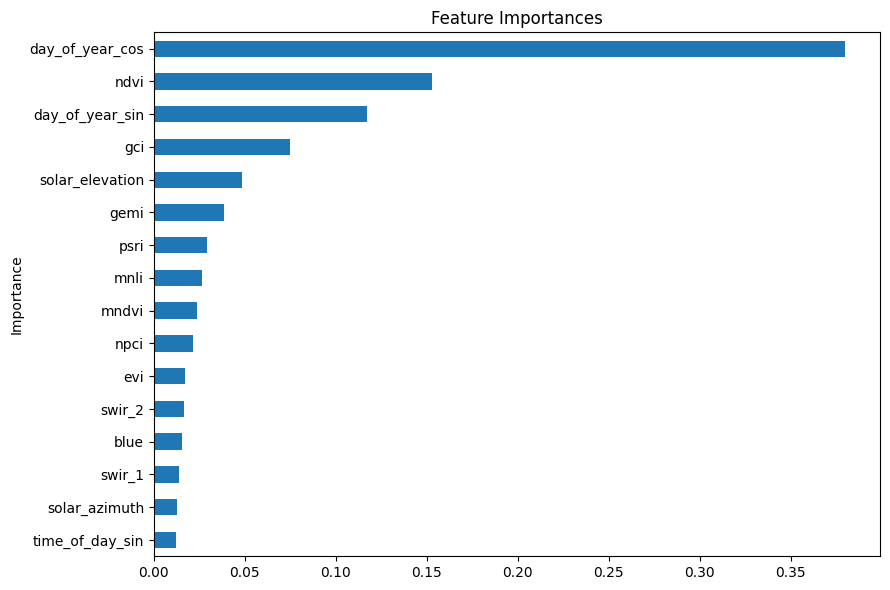

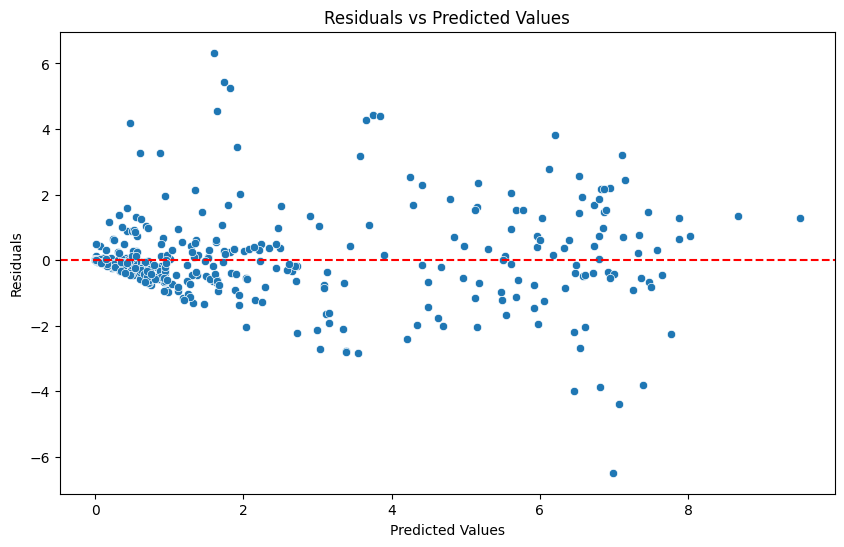

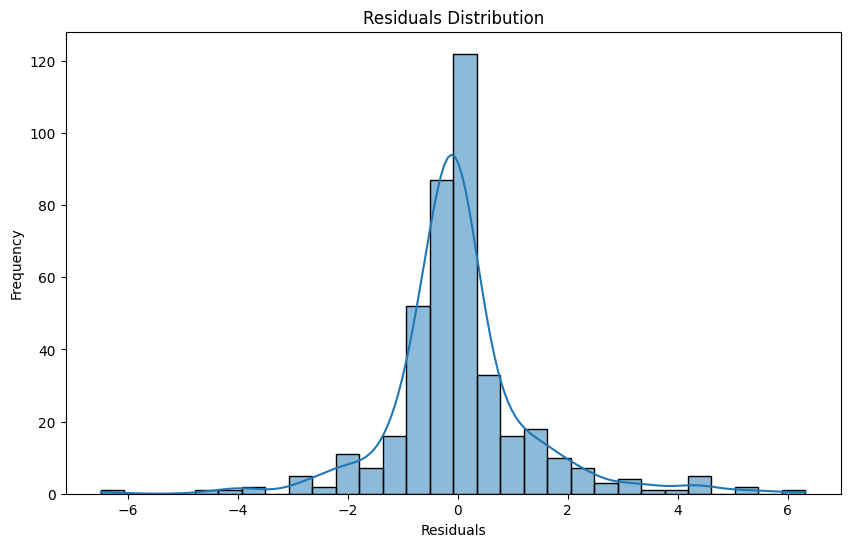

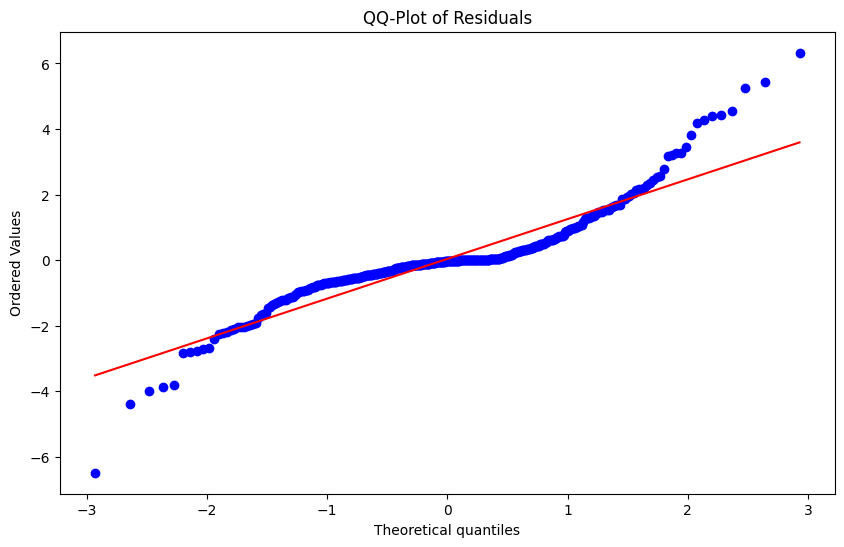

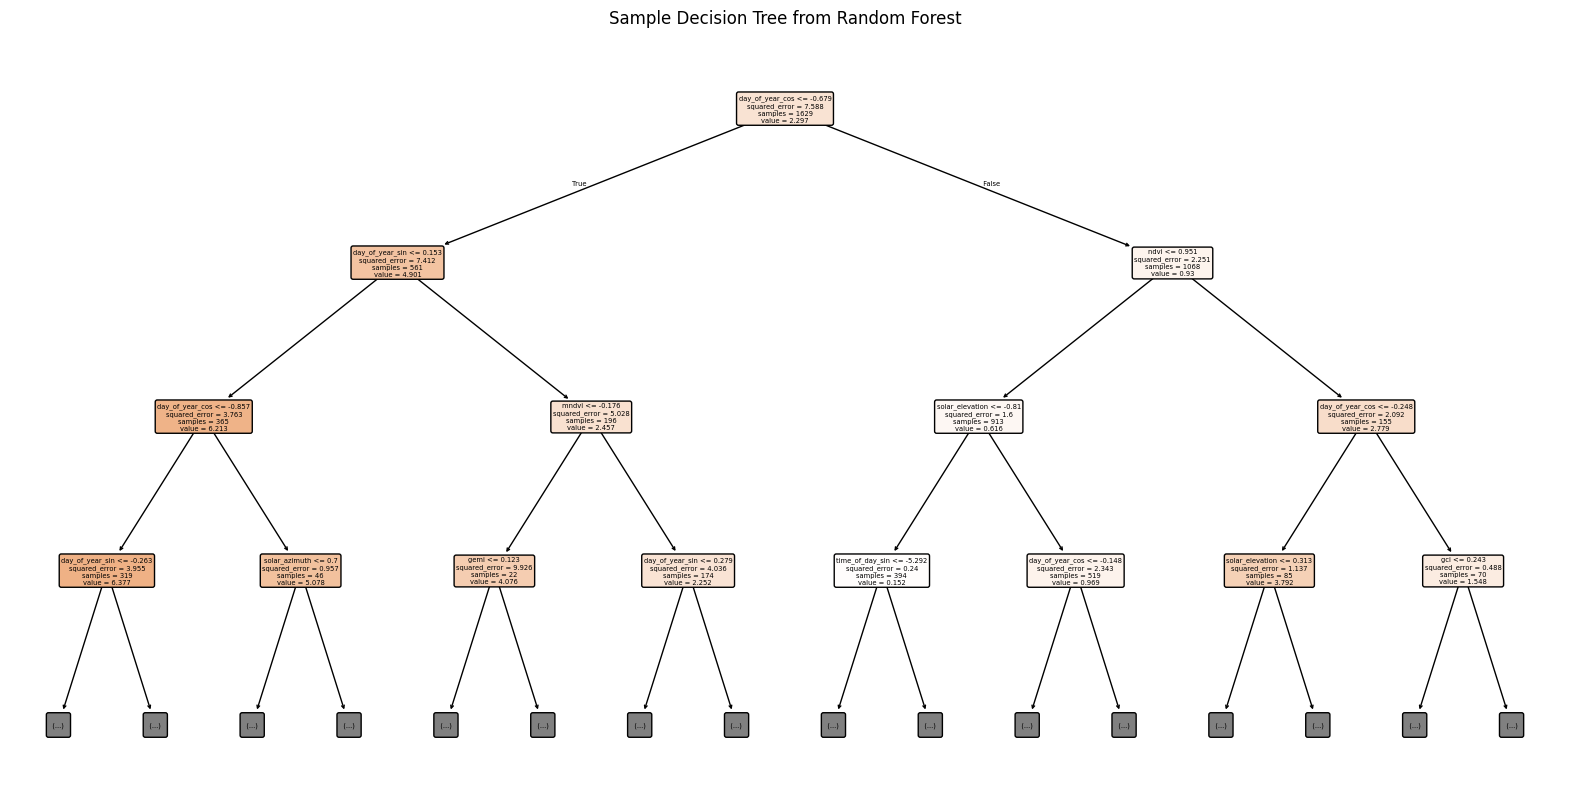

In [80]:
# Train, Evaluate, and Apply our model
site = "se_st1"
predicted = run_random_forest(
    df_train = data[site].training.copy(), # We've already dropped the cols from this dataframe during the train data prep stage. This one's been smoothed and some other things.
    df_unseen = data[site].satellite.drop(columns = col_filter, errors = "ignore").copy(), # Temporarily (for training purposes, drop the cols that are invalid for applying model/make our unseen data have the exact same columns as our training data.
    target_feature = "gpp",
    possible_hyperparameters = {
        "n_estimators": [100, 200, 300, 500, 1000],
        "max_depth": [None, 10, 20, 30, 50],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "max_features": [0.1, 0.3, 0.5, 0.7, 0.9, "sqrt", "log2"],
        'bootstrap': [True, False] # We should probably avoid allowing it to train on False. Whilst it may give better scores, it is at risk of overfitting.
        },
    categorical_features = [] # I've decided that platform_id shouldn't affect the model and it should be able to predict without it.
    )

#### Results
They should occupy similar space. We will compare the (un-prepped) non-smoothed paired data with the satellite data. Otherwise, if we compare unsmoothed, modelled GPPe from the satellite with smoothed in-situ GPP from the prepared, training-ready paired data, then it will look like it's not doing a good job!

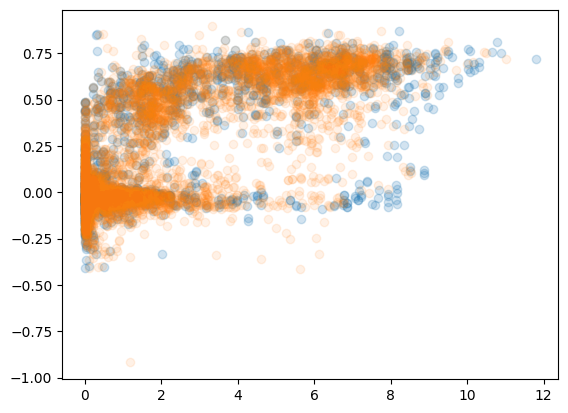

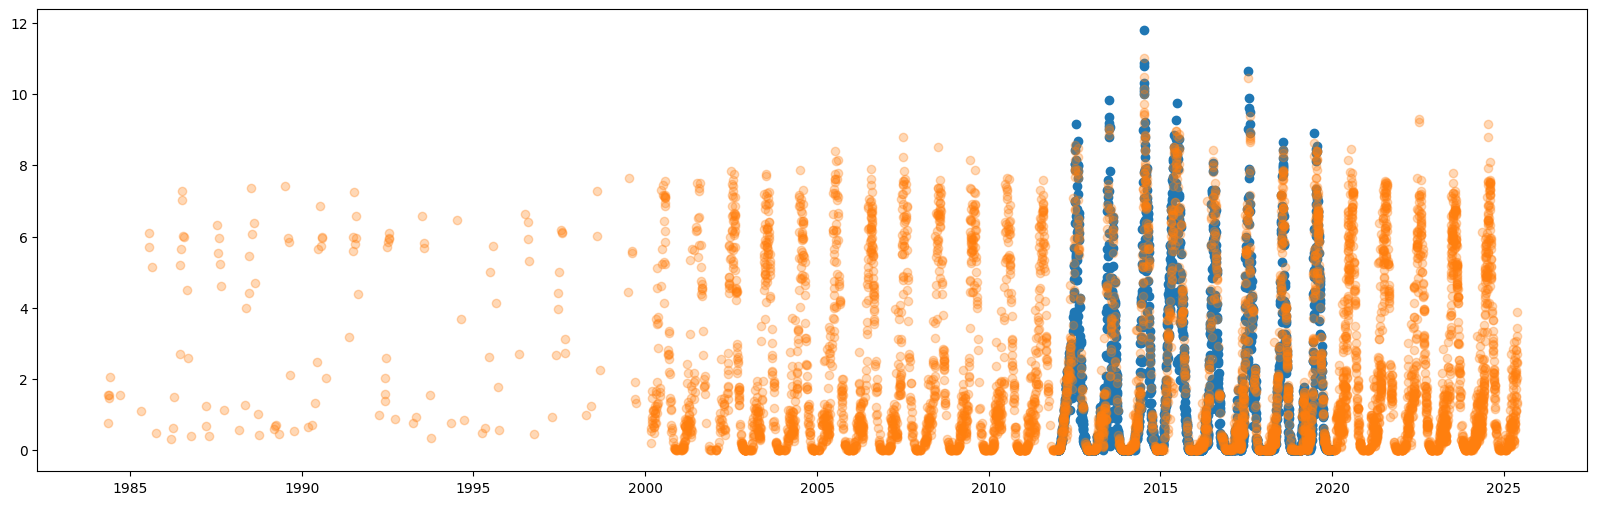

(np.float64(15340.0), np.float64(18262.0))

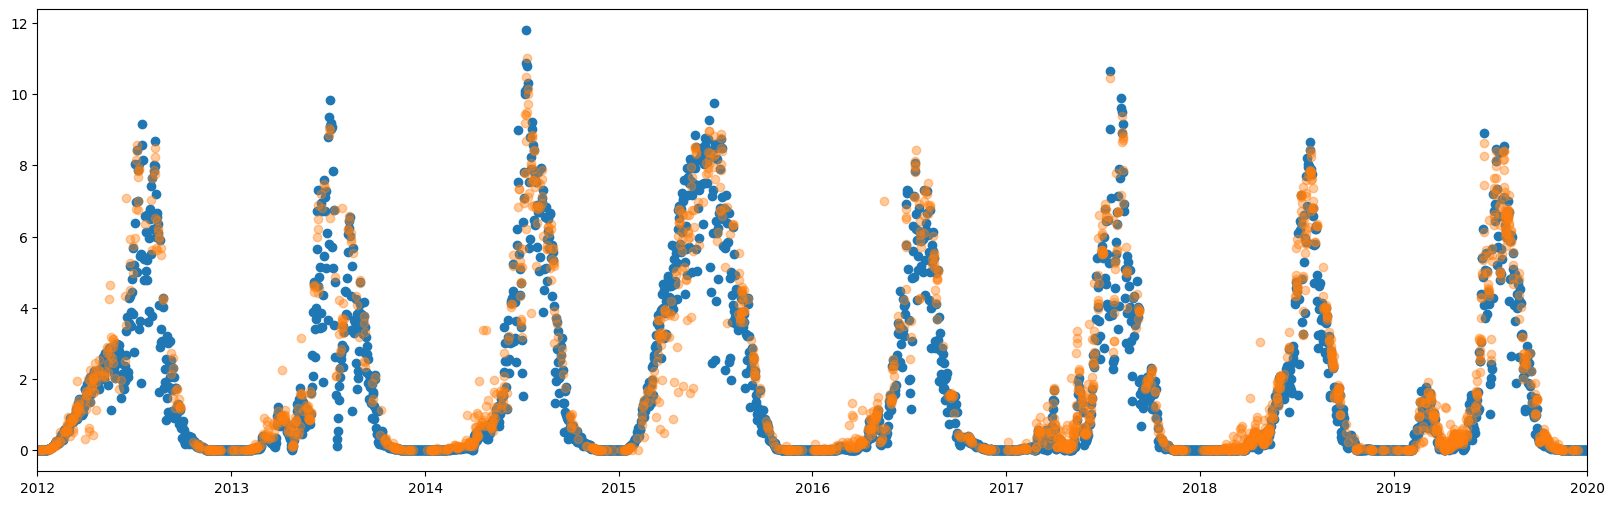

In [81]:
data[site].satellite["gppe"] = predicted

df_flux = data[site].flux.copy()
df_paired = data[site].paired.copy()
df_satellite = data[site].satellite.copy()

# Filter satellite the same way we did for paired
#df_satellite = df_satellite[df_satellite["ndvi"] >= 0.1]

# Plot
plt.scatter(df_paired["gpp"], df_paired["ndvi"], alpha = 0.2)
plt.scatter(df_satellite["gppe"], df_satellite["ndvi"], alpha = 0.1)
plt.show()

plt.figure(figsize=(20, 6))
plt.scatter(df_flux.index, df_flux["gpp"], alpha = 1)
plt.scatter(df_satellite.index, df_satellite["gppe"], alpha = 0.3)
plt.show()

fig, ax = plt.subplots(figsize = (20, 6))
ax.scatter(df_flux.index, df_flux["gpp"], alpha = 1)
ax.scatter(df_satellite.index, df_satellite["gppe"], alpha = 0.4)
ax.set_xlim(df_flux.index.min(), df_flux.index.max())